# Computer vision task: multi class image classification with using of pre-trained model on "Fruit and vegetables" dataset.

Import of main modules and libraries:

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.manifold import TSNE
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Extract images routes from train, test and validation folders:

In [2]:
train_dir = Path('drive/MyDrive/fruit_vegetables/train')
train_filepaths = list(train_dir.glob(r'*/*.*'))

test_dir = Path('drive/MyDrive/fruit_vegetables/test')
test_filepaths = list(test_dir.glob(r'*/*.*'))

validation_dir = Path('drive/MyDrive/fruit_vegetables/validation')
val_filepaths = list(validation_dir.glob(r'*/*.*'))

In [3]:
len(test_filepaths)

0

Define function for creating dataframe with image routes and their labels:

In [ ]:
def df_img(filepaths):
    
    #Create labels list
    labels = [str(filepaths[i]).split('/')[-2] for i in range(len(filepaths))]
    
    filepath = pd.Series(filepaths, name = 'Filepath').astype(str)
    labels = pd.Series(labels, name = 'Label')
    
    #Create dataframe with filepaths and their labels
    df = pd.concat([filepath, labels], axis =1)
    
    #Shufle dataframe with index reseting
    df = df.sample(frac = 1).reset_index(drop = True)
    
    return df

#Creating test, train and validation datasets 
test_df = df_img(test_filepaths)
train_df = df_img(train_filepaths)
val_df = df_img(val_filepaths)

Load the images with a generator and Data Augmentation with help of TensorFlow and Keras. Preprocessing images for pre-trained ResNet50 model:

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input )

train_images = image_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 1,
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest')

val_images = image_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 1,
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest' )

image_generator = tf.keras.preprocessing.image.ImageDataGenerator( 
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input )

test_images = image_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False )

Found 3115 validated image filenames belonging to 36 classes.
Found 351 validated image filenames belonging to 36 classes.
Found 359 validated image filenames belonging to 36 classes.


Download pre-trained model without "head" from Keras:

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


Train our ResNet50 model with 2 dense layers at the "top". Last dense layer has 36 neurons (due to number of classes) and softmax activation fuction.

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
output = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
 5/98 [>.............................] - ETA: 26:18 - loss: 3.6071 - accuracy: 0.1750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


44/98 [============>.................] - ETA: 17:56 - loss: 1.8249 - accuracy: 0.5298

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


98/98 [==============================] - 2149s 22s/step - loss: 1.2843 - accuracy: 0.6575 - val_loss: 0.3452 - val_accuracy: 0.8974
Epoch 2/100
98/98 [==============================] - 162s 2s/step - loss: 0.4010 - accuracy: 0.8671 - val_loss: 0.2215 - val_accuracy: 0.9345
Epoch 3/100
98/98 [==============================] - 165s 2s/step - loss: 0.2372 - accuracy: 0.9210 - val_loss: 0.1710 - val_accuracy: 0.9316
Epoch 4/100
98/98 [==============================] - 164s 2s/step - loss: 0.1447 - accuracy: 0.9554 - val_loss: 0.1359 - val_accuracy: 0.9601
Epoch 5/100
98/98 [==============================] - 164s 2s/step - loss: 0.0948 - accuracy: 0.9714 - val_loss: 0.1200 - val_accuracy: 0.9658
Epoch 6/100
98/98 [==============================] - 162s 2s/step - loss: 0.0670 - accuracy: 0.9817 - val_loss: 0.1474 - val_accuracy: 0.9573
Epoch 7/100
98/98 [==============================] - 165s 2s/step - loss: 0.0799 - accuracy: 0.9753 - val_loss: 0.0994 - val_accuracy: 0.9687
Epoch 8/100
98/9

Saving trained model:

In [ ]:
save_the_model = False
if save_the_model:
  model.save('drive/MyDrive/ResNet50_FV', save_format='h5')

Plotting of model loss and accuracy on the learning:

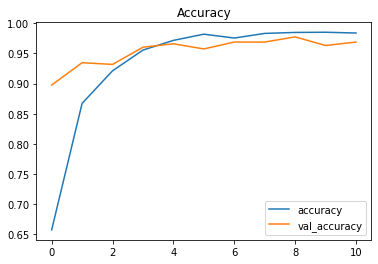

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

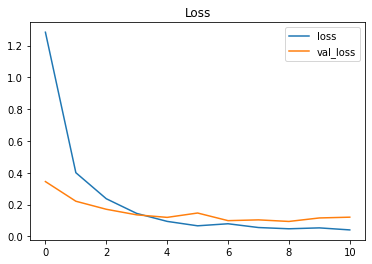

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

Make label predictions for the test set and compute accuracy:



In [ ]:
pred_0 = model.predict(test_images)
pred = np.argmax(pred_0,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Accuracy on the test set: 97.77%


# Creating 2-d image visualization

Make prediction with using of trained model without last prediction layer:

In [ ]:
load_model = False

if load_model:
  inputs = pretrained_model.input
  model = tf.keras.models.load_model('drive/MyDrive/ResNet50_FV')
  out = model.get_layer('dense').output
else:  
  out = model.layers[-2].output

model = tf.keras.Model(inputs=inputs, outputs=out) 
predict = model.predict(test_images)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Use T-SNE algorithm for dimension reduction of model results:

In [ ]:
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2)
reduced = tsne.fit_transform(predict)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 359 samples in 0.000s...
[t-SNE] Computed neighbors for 359 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 359 / 359
[t-SNE] Mean sigma: 12.151469
[t-SNE] Computed conditional probabilities in 0.045s
[t-SNE] Iteration 50: error = 64.5303421, gradient norm = 0.5986128 (50 iterations in 0.236s)
[t-SNE] Iteration 100: error = 64.9251709, gradient norm = 0.5723427 (50 iterations in 0.197s)
[t-SNE] Iteration 150: error = 65.4230042, gradient norm = 0.5869489 (50 iterations in 0.204s)
[t-SNE] Iteration 200: error = 65.4052658, gradient norm = 0.5746856 (50 iterations in 0.190s)
[t-SNE] Iteration 250: error = 65.4483109, gradient norm = 0.6010597 (50 iterations in 0.187s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.448311
[t-SNE] Iteration 300: error = 0.6848660, gradient norm = 0.0018995 (50 iterations in 0.156s)
[t-SNE] Iteration 350: error = 0.5966514, gradient norm = 0.0014549 

Normalization of T-SNE results:

In [ ]:
tx, ty = reduced[:,0], reduced[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

Build 2-d images projections:

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


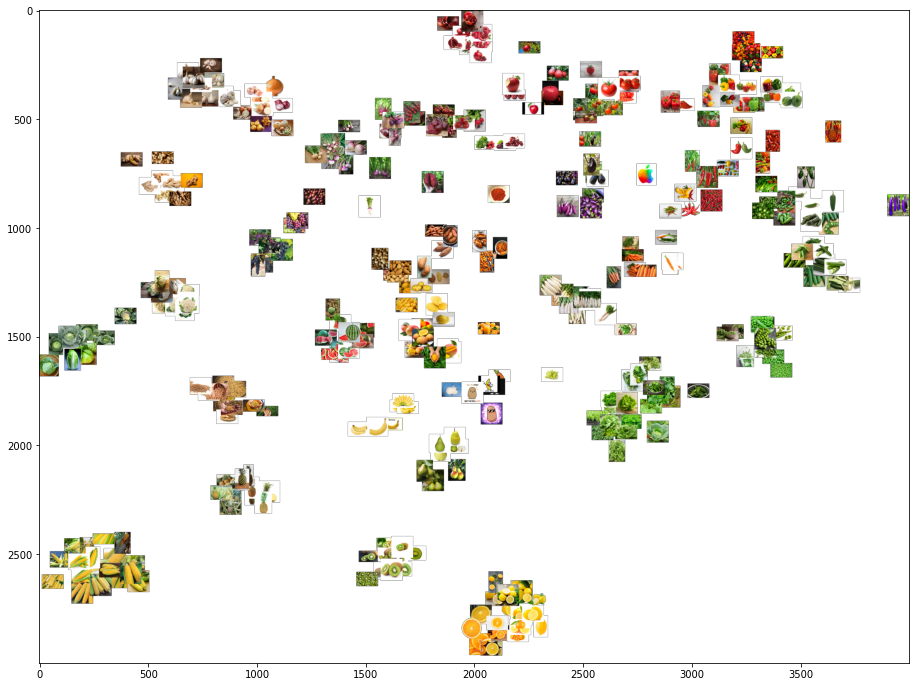

In [ ]:
width = 4000
height = 3000
max_dim = 100
save_to_png = False
te_filepath = test_df['Filepath'].tolist()

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(te_filepath, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
plt.figure(figsize = (16,12))
plt.imshow(full_image)

if save_to_png:
  full_image.save("drive/MyDrive/2d_tSNE_projection.png")